In [146]:
## Run pip install -r requirements.txt
%pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
import string

In [148]:
import pandas as pd
# Load the Excel file
complaints_df = pd.read_excel('./PI_Complaints.xlsx')

# Display the first few rows of the data
complaints_df.head()
complaints_df['Short Text']

0        Product malfunction / General Catalog Profile ...
1              Operation manual failure / PICO MASK /Japan
2           Sizing gauge is broken/AF541 Oro-Nasal Mask/JP
3                   foreign substance (hair)/TRILOGY/JAPAN
4          product scratch/ General Catalog Profile/ Japan
                               ...                        
21671                       Parts shortage/Dreamwear/Japan
21672    Received without a pillow and cushion/DreamWea...
21673    Received without a pillow and cushion/DreamWea...
21674                                                  NaN
21675                                                  NaN
Name: Short Text, Length: 21676, dtype: object

## Data Cleaning: Filter out the columns that aren't important

In [149]:

columns_to_drop = [
    'Notification Number'
]
# Drop columns
complaints_cleaned_df = complaints_df.drop(columns=columns_to_drop)

# Display cleaned DataFrame
complaints_cleaned_df.head()

,er key for sap and saptw notifications,Notification Date,Material Number,Material Description,Brand,Business,Code Description,SAP Damage Code Text,Short Text,Country,...,BreakDown Duration,Build Date,Ship To Customer,Ship To Party,Sold To Customer,Sold To Party,OOB Failure,Material Quantity,subject_long_text sor sap and srctw,Quantity
0,319015549.0,2024-09-05 06:24:00,1153533,Inspiredﾌﾛｰ用回路ﾁｬﾝﾊﾞ成人(F10)51007798,AC611,PATIENT INTERFACE,AC611 _ LEAK,LEAK,Product malfunction / General Catalog Profile ...,Japan,...,NaN,NaN,NaN,NaN,30302881.0,"Yagami Co.,Ltd.",No,1.0,NaN,1.0
1,319017578.0,2024-09-05 18:14:00,1104925,L PICO NASAL MASK W/ HGR JPN,PICO,PATIENT INTERFACE,PICO _ PHYS,PHYSICAL DAMAGE,Operation manual failure / PICO MASK /Japan,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,3.0,* 09/05/2024 10:39:50 EST (NMARRONE)\n* Per Er...,3.0
2,319017661.0,2024-09-05 18:14:00,1128652,"S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK",AF541,PATIENT INTERFACE,AF541 _ DMGP,"DAMAGE,PHYSICAL",Sizing gauge is broken/AF541 Oro-Nasal Mask/JP,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 10:52:31 EST (NMARRONE)\n* Per Er...,1.0
3,319018673.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ CONT,CONTAMINATION OBSERVED,foreign substance (hair)/TRILOGY/JAPAN,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:34:15 EST (NMARRONE)\n* Per Er...,1.0
4,319018807.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ COSM,COSMETIC DAMAGE,product scratch/ General Catalog Profile/ Japan,Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:36:49 EST (NMARRONE)\n* Per Er...,1.0


In [150]:
print(complaints_df.head())

  Notification Number  er key for sap and saptw notifications  \
0              100022                             319015549.0   
1              101106                             319017578.0   
2              101129                             319017661.0   
3              101249                             319018673.0   
4              101258                             319018807.0   

    Notification Date Material Number  \
0 2024-09-05 06:24:00         1153533   
1 2024-09-05 18:14:00         1104925   
2 2024-09-05 18:14:00         1128652   
3 2024-09-05 18:19:00          312149   
4 2024-09-05 18:19:00          312149   

                       Material Description           Brand  \
0        Inspiredﾌﾛｰ用回路ﾁｬﾝﾊﾞ成人(F10)51007798           AC611   
1              L PICO NASAL MASK W/ HGR JPN            PICO   
2  S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK           AF541   
3                Disp Exhalation Port Pk/10  PI ACCESSORIES   
4                Disp Exhalation Port Pk/10  PI

In [151]:

# complaints_df = complaints_df[[]]

# needed columns:
  # Country
  # possibly Sold to Party: maybe a trend among party complaints
  # Short Text: short description of complaint/issue
  # SAP Damage Code Text: the type of damage
  # possibly Brand: could be a trend among brands being an issue
  # Notification Date: possible trend among times with complaints
  # OOB Failure

unique_names = complaints_df['Country'].unique()

# Print the unique names
print("Unique Names:", unique_names)

country_code_mapping = {
    'JP': 'Japan',
    'US': 'United States',
    'NL': 'Netherlands',
    'IN': 'India',
    'GB': 'United Kingdom',
    'TH': 'Thailand',
    'FR': 'France',
    'DE': 'Germany',
    'CA': 'Canada',
    'ES': 'Spain',
    'AU': 'Australia',
    'NO': 'Norway',
    'AT': 'Austria',
    'CZ': 'Czech Republic',
    'KR': 'South Korea',
    'CN': 'China',
    'CO': 'Colombia',
    'MT': 'Malta',
    'HR': 'Croatia',
    'BE': 'Belgium',
    'PL': 'Poland',
    'ZA': 'South Africa',
    'JO': 'Jordan',
    'BR': 'Brazil',
    'HK': 'Hong Kong',
    'SE': 'Sweden',
    'IT': 'Italy',
    'EE': 'Estonia',
    'MY': 'Malaysia',
    'CH': 'Switzerland',
    'TR': 'Turkey',
    'PR': 'Puerto Rico',
    'TW': 'Taiwan',
    'SA': 'Saudi Arabia',
    'SG': 'Singapore',
    'GR': 'Greece',
    'Korea Republic of': 'South Korea'  # Handle alternate name
}


# Step 2: Standardize country names using the mapping
complaints_df['Country'] = complaints_df['Country'].replace(country_code_mapping)

# Step 3: Handle NaN values by replacing them with 'Unknown'
complaints_df = complaints_df.dropna(subset=['Country'])




# Step 4: Verify the cleaned country names
unique_names_cleaned = complaints_df['Country'].unique()
print("Cleaned Unique Country Names:", unique_names_cleaned)



Unique Names: ['Japan' 'United States' 'China' 'Thailand' 'Netherlands' 'Canada'
 'United Kingdom' 'Germany' 'JP' 'US' 'NL' 'IN' 'GB' 'TH' 'FR' 'DE' 'CA'
 'ES' 'AU' 'NO' 'AT' 'CZ' 'KR' 'CN' 'CO' 'MT' 'HR' 'BE' 'PL' 'ZA' 'JO'
 'BR' 'HK' 'SE' 'IT' 'EE' 'MY' 'CH' 'TR' 'PR' 'TW' 'SA' 'SG' 'GR' nan
 'Korea Republic of']
Cleaned Unique Country Names: ['Japan' 'United States' 'China' 'Thailand' 'Netherlands' 'Canada'
 'United Kingdom' 'Germany' 'India' 'France' 'Spain' 'Australia' 'Norway'
 'Austria' 'Czech Republic' 'South Korea' 'Colombia' 'Malta' 'Croatia'
 'Belgium' 'Poland' 'South Africa' 'Jordan' 'Brazil' 'Hong Kong' 'Sweden'
 'Italy' 'Estonia' 'Malaysia' 'Switzerland' 'Turkey' 'Puerto Rico'
 'Taiwan' 'Saudi Arabia' 'Singapore' 'Greece']


### Splitting by , or /

In [152]:
# Step 1: Split 'SAP Damage Code Text' by ',' and '/' into lists
complaints_df['SAP Damage Code Text'] = complaints_df['SAP Damage Code Text'].str.split(r'[,/]')

# Step 2: Use explode() to expand the lists into individual rows
complaints_df = complaints_df.explode('SAP Damage Code Text')

# Step 3: Strip any leading or trailing whitespace from the expanded values
complaints_df['SAP Damage Code Text'] = complaints_df['SAP Damage Code Text'].str.strip()

complaints_df

,Notification Number,er key for sap and saptw notifications,Notification Date,Material Number,Material Description,Brand,Business,Code Description,SAP Damage Code Text,Short Text,...,BreakDown Duration,Build Date,Ship To Customer,Ship To Party,Sold To Customer,Sold To Party,OOB Failure,Material Quantity,subject_long_text sor sap and srctw,Quantity
0,100022,319015549.0,2024-09-05 06:24:00,1153533,Inspiredﾌﾛｰ用回路ﾁｬﾝﾊﾞ成人(F10)51007798,AC611,PATIENT INTERFACE,AC611 _ LEAK,LEAK,Product malfunction / General Catalog Profile ...,...,NaN,NaN,NaN,NaN,30302881.0,"Yagami Co.,Ltd.",No,1.0,NaN,1.0
1,101106,319017578.0,2024-09-05 18:14:00,1104925,L PICO NASAL MASK W/ HGR JPN,PICO,PATIENT INTERFACE,PICO _ PHYS,PHYSICAL DAMAGE,Operation manual failure / PICO MASK /Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,3.0,* 09/05/2024 10:39:50 EST (NMARRONE)\n* Per Er...,3.0
2,101129,319017661.0,2024-09-05 18:14:00,1128652,"S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK",AF541,PATIENT INTERFACE,AF541 _ DMGP,DAMAGE,Sizing gauge is broken/AF541 Oro-Nasal Mask/JP,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 10:52:31 EST (NMARRONE)\n* Per Er...,1.0
2,101129,319017661.0,2024-09-05 18:14:00,1128652,"S, AF541 EE LK 1, Capstrap, JAPAN, 10 PK",AF541,PATIENT INTERFACE,AF541 _ DMGP,PHYSICAL,Sizing gauge is broken/AF541 Oro-Nasal Mask/JP,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 10:52:31 EST (NMARRONE)\n* Per Er...,1.0
3,101249,319018673.0,2024-09-05 18:19:00,312149,Disp Exhalation Port Pk/10,PI ACCESSORIES,PATIENT INTERFACE,PI ACCESSORIES _ CONT,CONTAMINATION OBSERVED,foreign substance (hair)/TRILOGY/JAPAN,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/05/2024 11:34:15 EST (NMARRONE)\n* Per Er...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21671,97402,319013643.0,2024-09-04 18:19:00,1153513,"DreamWear SP, S Fitpack, Japan",DREAMWEAR - SILICONE PILLOWS,PATIENT INTERFACE,DREAMWEAR - SILICONE PILLOWS _ MIAC,COMPONENT MISSING,Parts shortage/Dreamwear/Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/04/2024 13:40:48 EST (NMARRONE)\n* Per Er...,1.0
21671,97402,319013643.0,2024-09-04 18:19:00,1153513,"DreamWear SP, S Fitpack, Japan",DREAMWEAR - SILICONE PILLOWS,PATIENT INTERFACE,DREAMWEAR - SILICONE PILLOWS _ MIAC,INCOMPLETE,Parts shortage/Dreamwear/Japan,...,NaN,NaN,NaN,NaN,60600057.0,"SRC - Philips Japan, Ltd. - 539912",Yes,1.0,* 09/04/2024 13:40:48 EST (NMARRONE)\n* Per Er...,1.0
21672,97422,319012360.0,2024-09-04 18:19:00,1146468,"DreamWear SP, FitPack, GBL",DREAMWEAR - SILICONE PILLOWS,PATIENT INTERFACE,DREAMWEAR - SILICONE PILLOWS _ INCP,INCOMPLETE,Received without a pillow and cushion/DreamWea...,...,NaN,NaN,NaN,NaN,10101602.0,Customer Advocate,Not Requested,1.0,* 09/04/2024 11:59:52 EST (CPENCE)\n* Per emai...,1.0
21672,97422,319012360.0,2024-09-04 18:19:00,1146468,"DreamWear SP, FitPack, GBL",DREAMWEAR - SILICONE PILLOWS,PATIENT INTERFACE,DREAMWEAR - SILICONE PILLOWS _ INCP,INCORRECT PARTS,Received without a pillow and cushion/DreamWea...,...,NaN,NaN,NaN,NaN,10101602.0,Customer Advocate,Not Requested,1.0,* 09/04/2024 11:59:52 EST (CPENCE)\n* Per emai...,1.0


In [153]:
# complaints_cleaned_df
complaints_cleaned_df = complaints_df[['Notification Date', 'Brand', 'Country', 'Short Text', 'SAP Damage Code Text', 'OOB Failure']]


# country - short text
  # sentiments_df
  # sentiment analysis
  # ex. overall positive/negative
sentiments_df = complaints_df[['Country', 'Short Text']]

# country - notification date
notifications_df = complaints_df[['Country', 'Notification Date']]

# country - notification date - short text
sentiments_time_df = complaints_df[['Country', 'Notification Date', 'Short Text']]

sentiments_df.head()
notifications_df.head()
sentiments_time_df.head()

,Country,Notification Date,Short Text
0,Japan,2024-09-05 06:24:00,Product malfunction / General Catalog Profile ...
1,Japan,2024-09-05 18:14:00,Operation manual failure / PICO MASK /Japan
2,Japan,2024-09-05 18:14:00,Sizing gauge is broken/AF541 Oro-Nasal Mask/JP
2,Japan,2024-09-05 18:14:00,Sizing gauge is broken/AF541 Oro-Nasal Mask/JP
3,Japan,2024-09-05 18:19:00,foreign substance (hair)/TRILOGY/JAPAN


## Data Analysis over Time

/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_31733/2000489161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notifications_df['Notification Date'] = pd.to_datetime(notifications_df['Notification Date'])


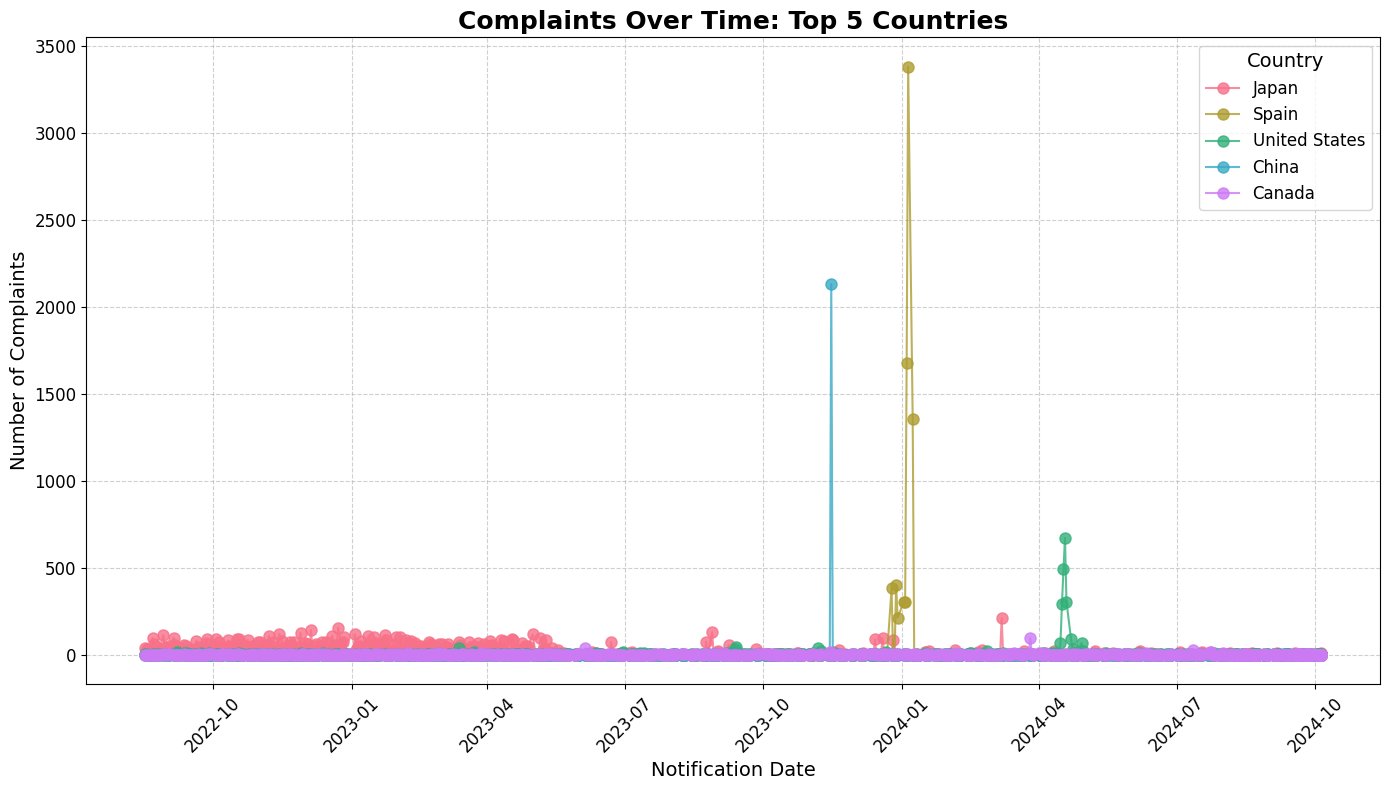

In [154]:
# Convert Notification Date to datetime
notifications_df['Notification Date'] = pd.to_datetime(notifications_df['Notification Date'])

# Group by Country and count total complaints per country
complaints_by_country = notifications_df.groupby('Country').size()

# Find the top 5 countries with the most complaints
top_5_countries = complaints_by_country.nlargest(5).index

# Group by Country and Notification Date, then count occurrences for plotting
complaints_over_time = notifications_df.groupby(['Country', 'Notification Date']).size().unstack(fill_value=0)

# Set up the color palette from Seaborn
palette = sns.color_palette('husl', len(top_5_countries))

# Plot for the top 5 countries
plt.figure(figsize=(14, 8))
lines_top_5 = []
for idx, country in enumerate(top_5_countries):
    line, = plt.plot(complaints_over_time.columns, complaints_over_time.loc[country], 
                     marker='o', markersize=8, linestyle='-', label=country, 
                     color=palette[idx], alpha=0.8)
    lines_top_5.append(line)

# Adding labels and title
plt.xlabel('Notification Date', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)
plt.title('Complaints Over Time: Top 5 Countries', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Country', loc='upper right', fontsize=12, title_fontsize=14)
plt.show()

/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_31733/361240381.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiments_time_df['Sentiment'] = sentiments_time_df['Short Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


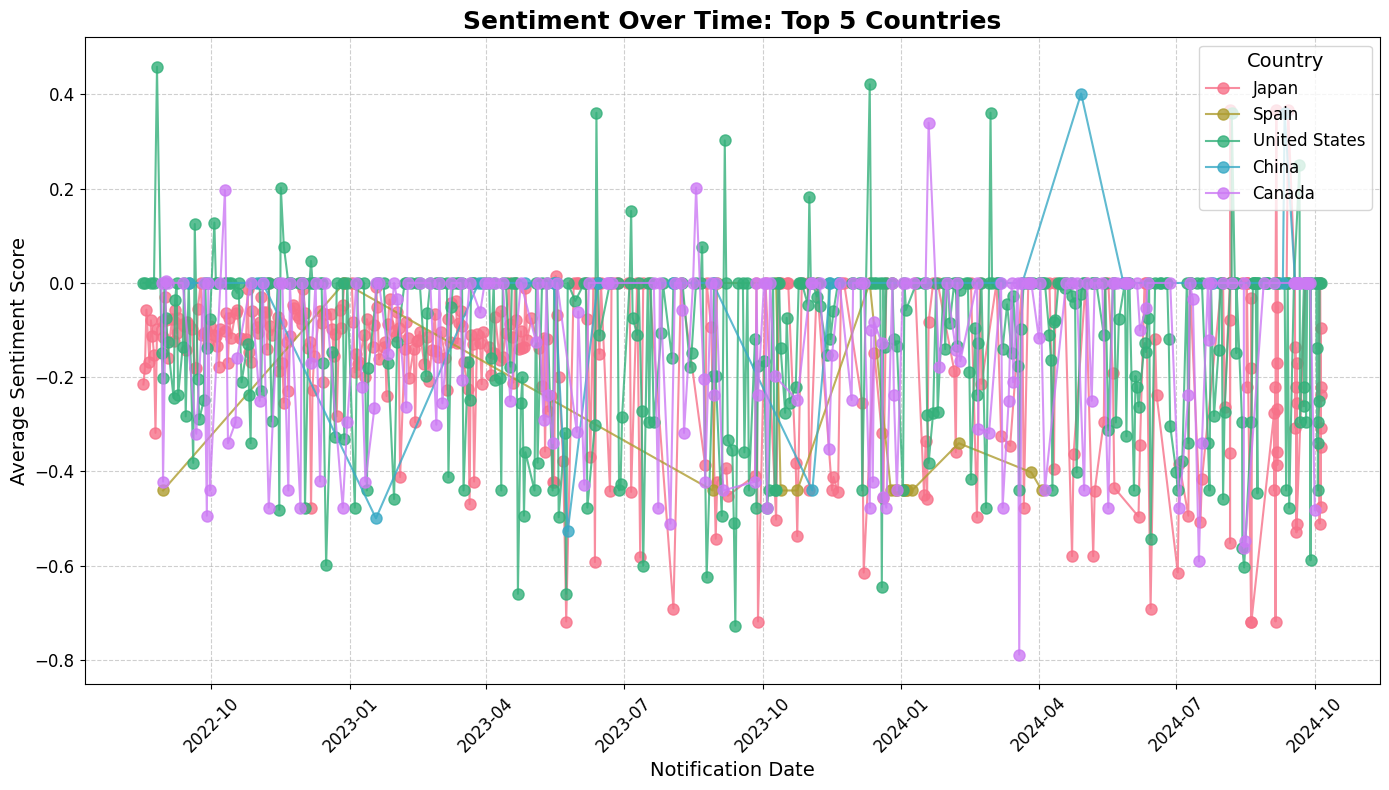

In [155]:
# Convert Notification Date to datetime
complaints_df['Notification Date'] = pd.to_datetime(complaints_df['Notification Date'])

# Group data by Country and Notification Date
sentiments_time_df = complaints_df[['Country', 'Notification Date', 'Short Text']]

# Perform sentiment analysis using VADER
analyzer = SentimentIntensityAnalyzer()
sentiments_time_df['Sentiment'] = sentiments_time_df['Short Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Find the top 5 countries with the most complaints
top_5_countries = complaints_df.groupby('Country').size().nlargest(5).index

# Filter the dataframe for the top 5 countries
filtered_sentiments_time_df = sentiments_time_df[sentiments_time_df['Country'].isin(top_5_countries)]

# Group by Country and Notification Date and take the average sentiment, ignoring non-numeric columns
average_sentiments = filtered_sentiments_time_df.groupby(['Country', 'Notification Date'])['Sentiment'].mean().reset_index()

# Set up the color palette from Seaborn
palette = sns.color_palette('husl', len(top_5_countries))

# Plot sentiments over time for the top 5 countries
plt.figure(figsize=(14, 8))
for idx, country in enumerate(top_5_countries):
    country_data = average_sentiments[average_sentiments['Country'] == country]
    plt.plot(country_data['Notification Date'], country_data['Sentiment'], 
             marker='o', markersize=8, linestyle='-', label=country, color=palette[idx], alpha=0.8)

# Adding labels and title
plt.xlabel('Notification Date', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.title('Sentiment Over Time: Top 5 Countries', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend(title='Country', loc='upper right', fontsize=12, title_fontsize=14)
plt.show()

In [156]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michellechang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michellechang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/michellechang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [157]:
# Display the number of unique values before standardization
print(f"Number of unique values before: {complaints_cleaned_df['SAP Damage Code Text'].nunique()}")

# Standardize the 'SAP Damage Code Text' column using .loc and a lambda function
complaints_cleaned_df.loc[:, 'SAP Damage Code Text'] = complaints_cleaned_df['SAP Damage Code Text'].apply(
    lambda x: x.replace('\xa0', ' ').strip().lower() if pd.notnull(x) else x
)

# Display the number of unique values after standardization
print(f"Number of unique values after: {complaints_cleaned_df['SAP Damage Code Text'].nunique()}")

complaints_cleaned_df['SAP Damage Code Text'].unique()

Number of unique values before: 246
Number of unique values after: 217


array(['leak', 'physical damage', 'damage', 'physical',
       'contamination observed', 'cosmetic damage', nan, 'seal',
       'customer check-recertify unit', 'contamination', 'labeling issue',
       'cushion wont stay attached to frame', 'adhesive will not apply',
       'mask', 'general cosmetic', 'elbow',
       'exhalation feature large leaks', 'durability issue', 'leaking',
       'rash', 'whistling noise', 'customer dissatisfaction',
       'user preferen', 'adhesive damage', 'cushion air leaks poor seal',
       'packaging damaged', 'foreign substance',
       'cushion separation from faceplate', 'conn', 'cushion cut',
       'split', 'tubing damaged or broken', 'cushion',
       'faceplate foreign substance', 'frame fitting issue', 'tubing cut',
       'sliced', 'cushion uncomfortable', 'fitting issue', '顧客の不満',
       'valve seal', 'flapper valve sticks',
       'accessories missing incomplete',
       'inquiry on sound abatement foam', 'carrier issue',
       'headgear chi

/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_31733/3642551879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints_df['Notification Date'] = pd.to_datetime(complaints_df['Notification Date'])


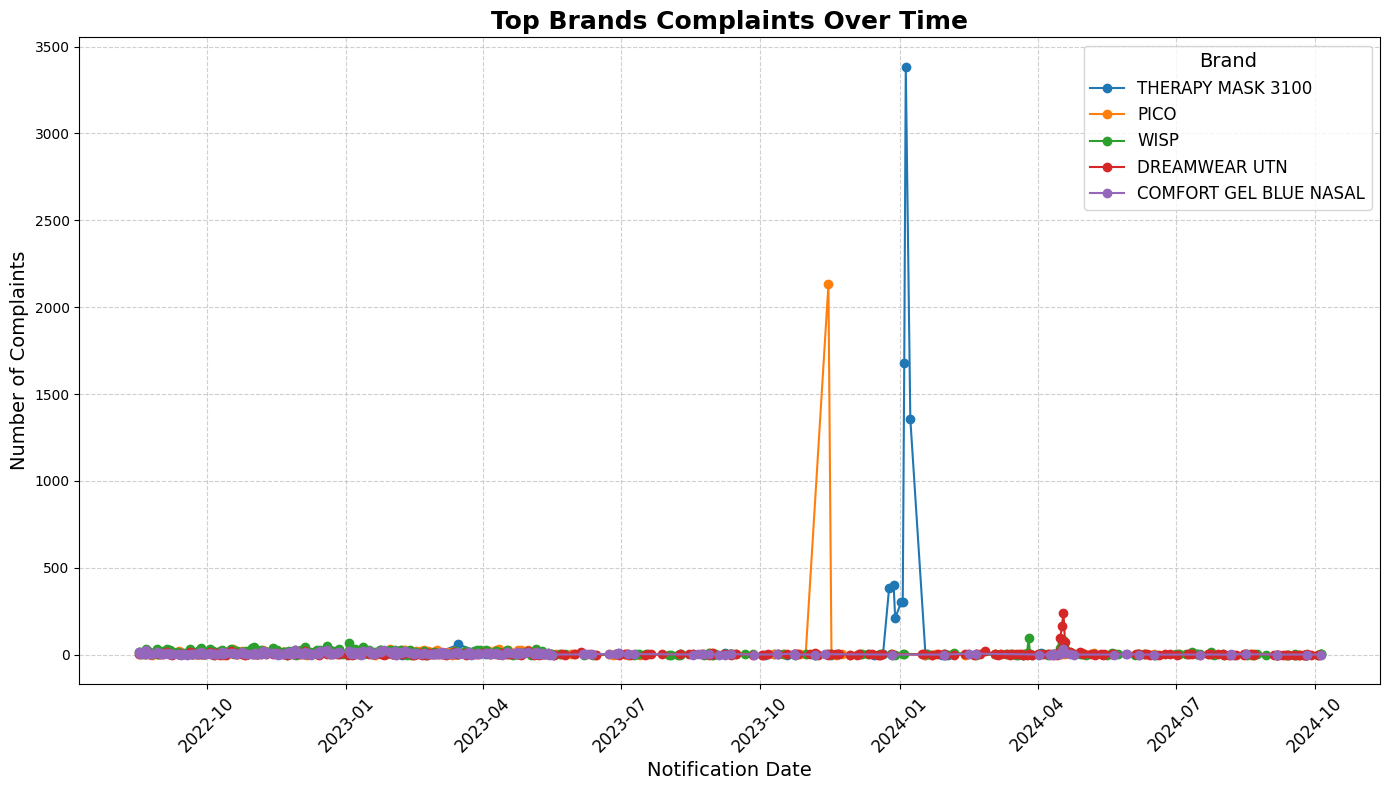

In [158]:
# Assuming complaints_cleaned_df is already loaded
complaints_df = complaints_cleaned_df

# Convert 'Notification Date' to datetime
complaints_df['Notification Date'] = pd.to_datetime(complaints_df['Notification Date'])

# Find the top brands with the most complaints (e.g., top 5)
top_brands = complaints_df['Brand'].value_counts().nlargest(5).index

# Filter the DataFrame to only include the top brands
filtered_complaints_df = complaints_df[complaints_df['Brand'].isin(top_brands)]

# Group by 'Brand' and 'Notification Date' to count the number of complaints over time
complaints_over_time = filtered_complaints_df.groupby(['Brand', 'Notification Date']).size().reset_index(name='Complaint Count')

# Plot complaints over time for each of the top brands
plt.figure(figsize=(14, 8))

# Plot each top brand's complaint count over time
for brand in top_brands:
    brand_data = complaints_over_time[complaints_over_time['Brand'] == brand]
    plt.plot(brand_data['Notification Date'], brand_data['Complaint Count'], marker='o', linestyle='-', label=brand)

# Adding labels and title
plt.xlabel('Notification Date', fontsize=14)
plt.ylabel('Number of Complaints', fontsize=14)
plt.title('Top Brands Complaints Over Time', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Brand', loc='upper right', fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [159]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: Un

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 107}
Test Accuracy: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.11      0.08         9
           1       0.93      0.99      0.96        84
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        20
           4       0.33      0.38      0.35       203
           5       0.99      0.99      0.99       637
           6       0.00      0.00      0.00         0
           7       0.06      0.55      0.11        11
           8       0.14      1.00      0.25         2
           9       0.03      0.08      0.04        13
          10       0.05      0.36      0.09        11
          11       0.18      0.35      0.24        17
          12       0.00      0.00      0.00         1
          13       0.84      1.00      0.91        26
          14       0.00      0.00 

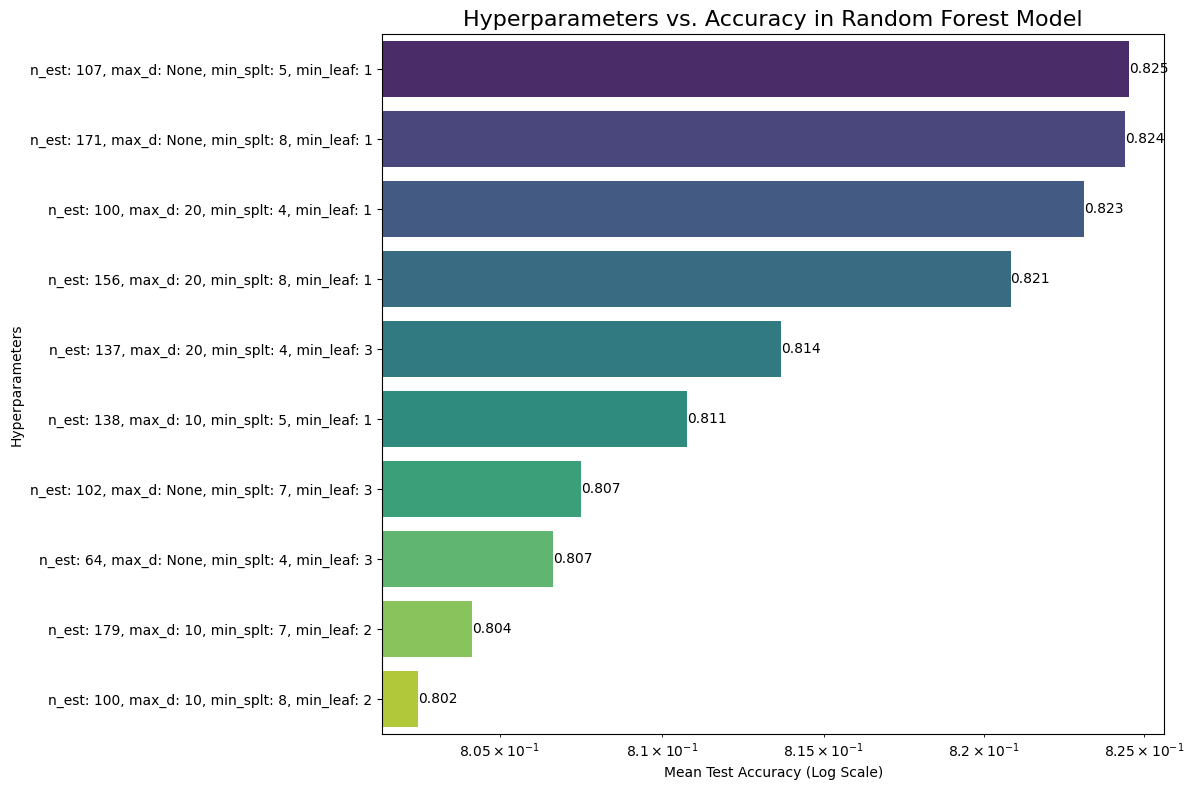

/var/folders/j2/0vyt056x6wsb7gmp2wt8n6c80000gn/T/ipykernel_31733/3582411188.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


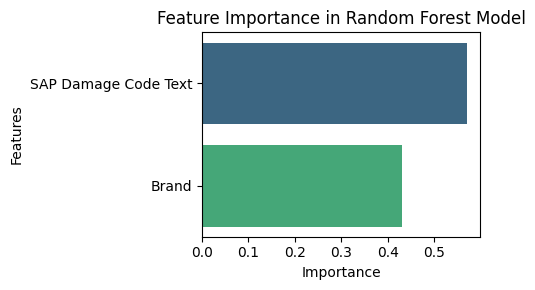

In [179]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming complaints_cleaned_df is already loaded
complaints_df = complaints_cleaned_df.copy()

# Step 1: Data Preparation - Handling missing values and selecting relevant columns
complaints_df.fillna('Unknown', inplace=True)

# Only consider the columns 'Brand', 'SAP Damage Code Text', and 'Country'
columns_for_analysis = ['Brand', 'SAP Damage Code Text', 'Country']
complaints_df = complaints_df[columns_for_analysis]

# Step 2: Apply Label Encoding for 'Brand', 'SAP Damage Code Text', and 'Country'
label_encoders = {}
for col in ['Brand', 'SAP Damage Code Text', 'Country']:
    le = LabelEncoder()
    complaints_df[col] = le.fit_transform(complaints_df[col])
    label_encoders[col] = le

# Step 3: Define the features and the target
features = complaints_df.drop('Country', axis=1)
target = complaints_df['Country']

# Step 4: Feature Scaling (Standardizing data)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 5: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, target, test_size=0.3, random_state=42
)

# Step 6: Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),  # Fewer estimators for speed
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4)
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

rand_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                 n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)

rand_search.fit(X_train, y_train)

# Step 7: Use the best model from RandomizedSearchCV
best_rf_model = rand_search.best_estimator_

# Step 8: Make predictions on the test set
y_test_pred = best_rf_model.predict(X_test)

# Step 9: Evaluate the model
test_accuracy = accuracy_score(y_test, y_test_pred)
classification_report_str = classification_report(y_test, y_test_pred)

print(f"Best Hyperparameters: {rand_search.best_params_}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print("\nClassification Report:\n", classification_report_str)

# Step 10: Bar chart of hyperparameters and their corresponding accuracies

# Extract hyperparameter combinations and mean test scores from RandomizedSearchCV results
cv_results = pd.DataFrame(rand_search.cv_results_)

# Concatenate hyperparameters into a shorter string for visualization
cv_results['Hyperparameters'] = (
    'n_est: ' + cv_results['param_n_estimators'].astype(str) + ', ' +
    'max_d: ' + cv_results['param_max_depth'].astype(str) + ', ' +
    'min_splt: ' + cv_results['param_min_samples_split'].astype(str) + ', ' +
    'min_leaf: ' + cv_results['param_min_samples_leaf'].astype(str)
)

# Select relevant columns
cv_results_subset = cv_results[['Hyperparameters', 'mean_test_score']]

# Sort by mean_test_score for better visualization
cv_results_subset = cv_results_subset.sort_values(by='mean_test_score', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=cv_results_subset, x='mean_test_score', y='Hyperparameters', palette='viridis')
plt.xscale('log')  # Use a logarithmic scale for the x-axis
plt.xlabel('Mean Test Accuracy (Log Scale)')
plt.ylabel('Hyperparameters')
plt.title('Hyperparameters vs. Accuracy in Random Forest Model', fontsize=16, loc='center')  # Centered title

# Display the accuracy as text on the right side of each bar
for i, (acc, label) in enumerate(zip(cv_results_subset['mean_test_score'], cv_results_subset['Hyperparameters'])):
    ax.text(acc, i, f'{acc:.3f}', va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()



# Step 11: Feature Importance
feature_importances = best_rf_model.feature_importances_
feature_names = features.columns

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualize feature importance with best parameters in the title
plt.figure(figsize=(5, 3))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title(f"Feature Importance in Random Forest Model")
plt.tight_layout()
plt.show()


In [161]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import randint

# Assuming complaints_cleaned_df is already loaded
complaints_df = complaints_cleaned_df.copy()

# Step 1: Data Preparation - Handling missing values and selecting relevant columns
complaints_df.fillna('Unknown', inplace=True)

# Only consider the columns 'Brand', 'SAP Damage Code Text', and 'Country'
columns_for_analysis = ['Brand', 'SAP Damage Code Text', 'Country']
complaints_df = complaints_df[columns_for_analysis]

# Step 2: Apply Label Encoding for 'Brand', 'SAP Damage Code Text', and 'Country'
label_encoders = {}
for col in ['Brand', 'SAP Damage Code Text', 'Country']:
    le = LabelEncoder()
    complaints_df[col] = le.fit_transform(complaints_df[col])
    label_encoders[col] = le

# Step 3: Define the features and the target
features = complaints_df.drop('Brand', axis=1)
target = complaints_df['Brand']

# Step 4: Feature Scaling (Standardizing data)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 5: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, target, test_size=0.3, random_state=42
)

# Step 6: Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),  # Range of trees
    'max_depth': [None, 10, 20],       # Max depth
    'min_samples_split': randint(2, 10),  # Min samples to split
    'min_samples_leaf': randint(1, 4)  # Min samples in leaf
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

rand_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,  # 10 random combinations
    scoring='accuracy',
    cv=3,       # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit RandomizedSearchCV to find the best parameters
rand_search.fit(X_train, y_train)

# Step 7: Use the best model from RandomizedSearchCV
best_rf_model = rand_search.best_estimator_

# Step 8: Make predictions on the test set
y_test_pred = best_rf_model.predict(X_test)

# Step 9: Evaluate the model
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Best Hyperparameters: {rand_search.best_params_}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Test Accuracy: 0.54

Classification Report:
               precision    recall  f1-score   support

           1       0.08      0.40      0.13         5
           2       0.20      0.02      0.03        57
           3       0.01      0.33      0.03        18
           4       0.12      0.13      0.12        78
           5       0.09      0.20      0.12       158
           6       0.33      0.11      0.17       227
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.05      0.09      0.07        34
          10       0.79      0.26      0.39       513
          11       0.00      0.00      0.00         0
          12       0.47      0.63      0.54        94
          13       0.39      0.21      0.27       226
          14       0.04      0.04      0.04        26
          15       0.56      0.06   

/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'C': uniform(0.01, 10),          # Regularization strength
    'penalty': ['l1', 'l2'],         # Regularization type
    'solver': ['liblinear', 'saga'], # Solvers that work with 'l1' and 'l2'
    'max_iter': [500, 1000]          # Iterations for convergence
}

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(class_weight='balanced', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=log_reg_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of random samples to try
    scoring='accuracy',
    cv=3,       # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit RandomizedSearchCV to find the best parameters
random_search.fit(X_train, y_train)

# Use the best model found by RandomizedSearchCV
best_log_reg_model = random_search.best_estimator_

# Make predictions on the test set
y_test_pred = best_log_reg_model.predict(X_test)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Best Hyperparameters: {'C': 0.08066305219717405, 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.44

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        57
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        78
           5       0.00      0.00      0.00       158
           6       0.00      0.00      0.00       227
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00        34
          10       0.00      0.00      0.00       513
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00        94
          13       0.00      0.00      0.00       226
          14       0.00      0.00      0.00        26
          15       0.00      0.00     

/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/michellechang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 